<a href="https://colab.research.google.com/github/Kaibalya27/Functional_API_Age_Gender/blob/main/Age_gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 330M/331M [00:06<00:00, 93.4MB/s]
100% 331M/331M [00:06<00:00, 55.6MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("utkface-new.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

In [ ]:
age=[]
gender=[]
path=[]
for i in os.listdir('/content/utkface_aligned_cropped/UTKFace'):
  age.append(int(i.split('_')[0]))
  gender.append(int(i.split('_')[1]))
  path.append(i)

In [ ]:
df=pd.DataFrame({'age':age,'gender':gender,'img':path})
df

,age,gender,img
0,23,1,23_1_0_20170117145031171.jpg.chip.jpg
1,35,0,35_0_0_20170117134936879.jpg.chip.jpg
2,90,1,90_1_0_20170110180120743.jpg.chip.jpg
3,43,1,43_1_0_20170103183515393.jpg.chip.jpg
4,45,1,45_1_0_20170109135632551.jpg.chip.jpg
...,...,...,...
23703,80,0,80_0_0_20170111211441005.jpg.chip.jpg
23704,32,0,32_0_1_20170114031959964.jpg.chip.jpg
23705,26,1,26_1_1_20170112233658982.jpg.chip.jpg
23706,26,0,26_0_0_20170120134255183.jpg.chip.jpg


In [ ]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(df,test_size=0.2,random_state=42)

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_iterator = train_gen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/utkface_aligned_cropped/UTKFace',
    x_col='img',
    y_col=['age', 'gender'],
    target_size=(200, 200),
    class_mode='raw',
    batch_size=16
)

test_iterator = test_gen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/utkface_aligned_cropped/UTKFace',
    x_col='img',
    y_col=['age', 'gender'],
    target_size=(200, 200),
    class_mode='raw',
    batch_size=16
)
def custom_data_generator(generator):
    while True:
        x_batch, y_batch = next(generator)
        y_age = y_batch[:, 0].astype('float32')
        y_gender = y_batch[:, 1].astype('float32')
        yield x_batch, {'Age': y_age, 'Gender': y_gender}

# Create custom generators
train_generator = custom_data_generator(train_iterator)
test_generator = custom_data_generator(test_iterator)

Found 18966 validated image filenames.
Found 4742 validated image filenames.


In [ ]:
vgg16=tf.keras.applications.VGG16(include_top=False,input_shape=(200,200,3))
vgg16.trainable=False
for i in vgg16.layers:
  if 'block5' in i.name:
    i.trainable=True
  print(i.name,i.trainable)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
output = vgg16.output
f = Flatten()(output)

# Age prediction branch
hidden_age_1 = Dense(512, activation='relu')(f)
bn_age_1 = BatchNormalization()(hidden_age_1)
hidden_age_2 = Dense(512, activation='relu')(bn_age_1)
bn_age_2 = BatchNormalization()(hidden_age_2)
dropout_age1=Dropout(0.3)(bn_age_2)
hidden_age_3 = Dense(256, activation='relu')(dropout_age1)
bn_age_3 = BatchNormalization()(hidden_age_3)
hidden_age_4 = Dense(256, activation='relu')(bn_age_3)
bn_age_4 = BatchNormalization()(hidden_age_4)
dropout_age2=Dropout(0.3)(bn_age_4)
hidden_age_5 = Dense(128, activation='relu')(dropout_age2)
bn_age_5 = BatchNormalization()(hidden_age_5)
hidden_age_6 = Dense(64, activation='relu')(bn_age_5)
bn_age_6 = BatchNormalization()(hidden_age_6)
dropout_age3=Dropout(0.6)(bn_age_6)
hidden_age_7 = Dense(64, activation='relu')(dropout_age3)
bn_age_7 = BatchNormalization()(hidden_age_7)
output_age = Dense(1, activation='linear', name='Age')(bn_age_7)

# Gender prediction branch
hidden_gender_1 = Dense(512, activation='relu')(f)
bn_gender_1 = BatchNormalization()(hidden_gender_1)
hidden_gender_2 = Dense(512, activation='relu')(bn_gender_1)
bn_gender_2 = BatchNormalization()(hidden_gender_2)
hidden_gender_3 = Dense(256, activation='relu')(bn_gender_2)
bn_gender_3 = BatchNormalization()(hidden_gender_3)
hidden_gender_4 = Dense(256, activation='relu')(bn_gender_3)
bn_gender_4 = BatchNormalization()(hidden_gender_4)
hidden_gender_5 = Dense(128, activation='relu')(bn_gender_4)
bn_gender_5 = BatchNormalization()(hidden_gender_5)
hidden_gender_6 = Dense(64, activation='relu')(bn_gender_5)
bn_gender_6 = BatchNormalization()(hidden_gender_6)
hidden_gender_7 = Dense(32, activation='relu')(bn_gender_6)
bn_gender_7 = BatchNormalization()(hidden_gender_7)
hidden_gender_8 = Dense(16, activation='relu')(bn_gender_7)
bn_gender_8 = BatchNormalization()(hidden_gender_8)
hidden_gender_9=Dense(8, activation='relu')(bn_gender_8)
bn_gender_9=BatchNormalization()(hidden_gender_9)
output_gender = Dense(1, activation='sigmoid', name='Gender')(bn_gender_9)
model = Model(inputs=vgg16.input, outputs=[output_age, output_gender])

In [ ]:
model.compile(optimizer='adam', loss={'Age': 'mae', 'Gender': 'binary_crossentropy'}, metrics={'Age': 'mae', 'Gender': 'accuracy'},loss_weights={'Age':0.01,'Gender':0.99})

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

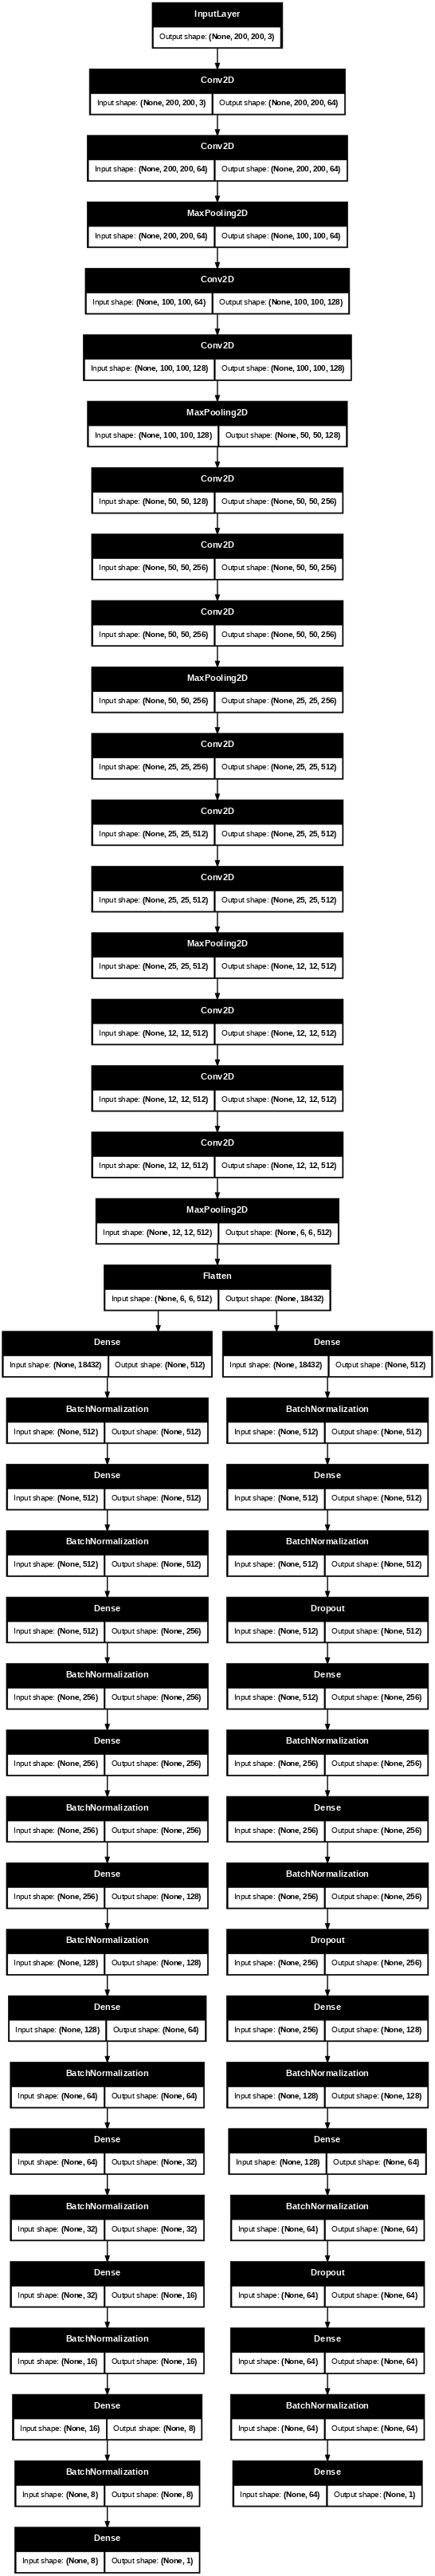

In [ ]:
from keras.utils import plot_model
plot_model(model,show_shapes=True, dpi=50)

In [ ]:
import math
batch_size = 16
steps_per_epoch = math.ceil(len(train_df) / batch_size)
validation_steps = math.ceil(len(test_df) / batch_size)

model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=17,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[callback]
)
model.save('age_gender_model.h5')

Epoch 1/17
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 269s 211ms/step - Age_mae: 23.4796 - Gender_accuracy: 0.8055 - loss: 0.6376 - val_Age_mae: 9.4550 - val_Gender_accuracy: 0.8722 - val_loss: 0.3835
Epoch 2/17
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 238s 201ms/step - Age_mae: 9.9498 - Gender_accuracy: 0.8483 - loss: 0.4344 - val_Age_mae: 32.2552 - val_Gender_accuracy: 0.7864 - val_loss: 1.1117
Epoch 3/17
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 239s 201ms/step - Age_mae: 9.8251 - Gender_accuracy: 0.8485 - loss: 0.4261 - val_Age_mae: 19.6150 - val_Gender_accuracy: 0.8954 - val_loss: 0.6072
Epoch 4/17
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 238s 201ms/step - Age_mae: 9.4653 - Gender_accuracy: 0.8578 - loss: 0.4142 - val_Age_mae: 8.2219 - val_Gender_accuracy: 0.8916 - val_loss: 0.3403
Epoch 5/17
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 253s 213ms/step - Age_mae: 9.3032 - Gender_accuracy: 0.8692 - loss: 0.3925 - val_Age_mae: 8.9220 - val_Gender_accuracy: 0.8908 - val_loss: 0.4403
Epoch 6/17
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 232s 196ms/step

In [ ]:
model.evaluate(test_generator,steps=validation_steps)

297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - Age_mae: 7.1667 - Gender_accuracy: 0.9042 - loss: 0.2984


[0.3059331774711609, 7.348485946655273, 0.903838038444519]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.save('/content/drive/MyDrive/age_gender_model.h5')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanAbsoluteError
custom_objects = {'mae': MeanAbsoluteError()}
model = load_model('/content/drive/MyDrive/age_gender_model.h5', custom_objects=custom_objects)

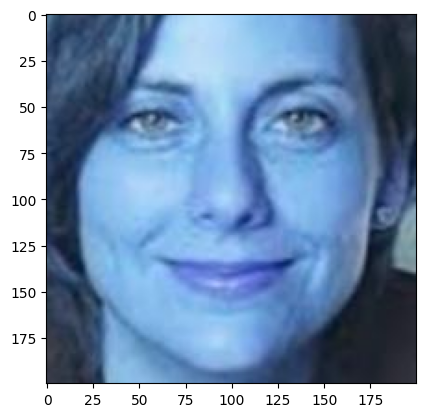

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


[array([[36.62718]], dtype=float32), array([[1.]], dtype=float32)]

In [ ]:
test_img=cv2.imread('/content/utkface_aligned_cropped/UTKFace/35_1_0_20170103182348593.jpg.chip.jpg')
test_img=cv2.resize(test_img,(200,200))
test_input=test_img.reshape((1,200,200,3))
plt.imshow(test_img)
plt.show()
model.predict(test_input)

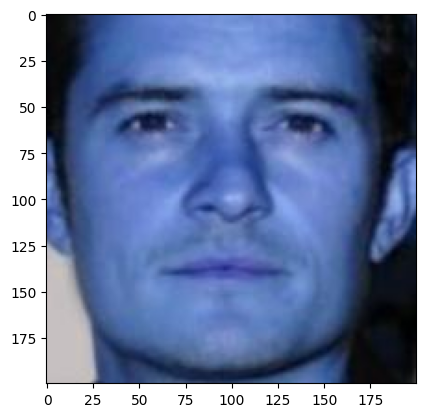

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


[array([[31.225348]], dtype=float32), array([[0.]], dtype=float32)]

In [ ]:
test_img=cv2.imread('/content/utkface_aligned_cropped/UTKFace/28_0_0_20170117180137421.jpg.chip.jpg')
test_img=cv2.resize(test_img,(200,200))
test_input=test_img.reshape((1,200,200,3))
plt.imshow(test_img)
plt.show()
model.predict(test_input)